In [1]:
pip install triangle

Note: you may need to restart the kernel to use updated packages.


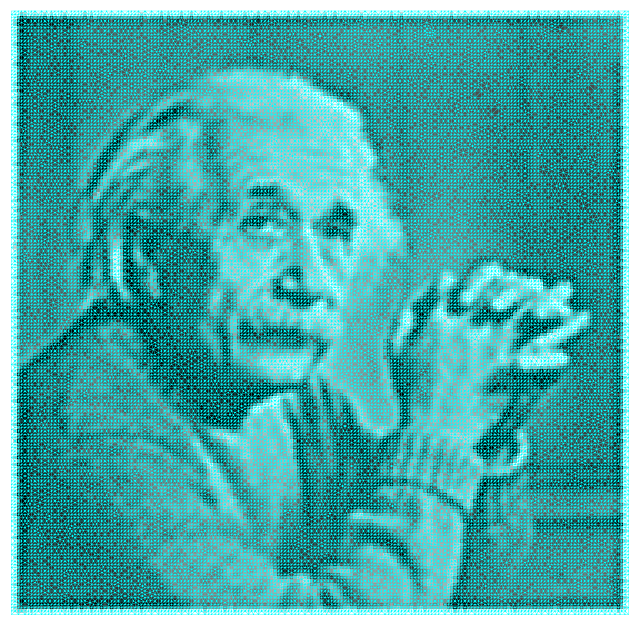

In [3]:
import numpy as np
from PIL import Image, ImageFilter
import triangle as tr
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# 1. Tạo mesh hỗn hợp gradient + uniform
# 2. Weighted Mean Filter (k láng giềng)
# 3. Chuẩn hóa, UnsharpMask và vẽ overlay mesh

def create_adaptive_mesh(image_path, num_seed_points=50000,
                         grad_frac=0.7, quality_angle=30, max_area=20):
    img = Image.open(image_path).convert('L')
    image_array = np.array(img)
    h, w = image_array.shape

    # Gradient-driven seeding
    ys, xs = np.gradient(image_array.astype(float))
    grad_mag = np.hypot(xs, ys)
    grad_prob = grad_mag / grad_mag.sum()
    n_grad = int(num_seed_points * grad_frac)
    n_uni = num_seed_points - n_grad
    idx_grad = np.random.choice(h*w, size=n_grad, p=grad_prob.ravel())
    idx_uni = np.random.choice(h*w, size=n_uni, replace=False)
    seeds_grad = np.column_stack((idx_grad % w, idx_grad // w))
    seeds_uni = np.column_stack((idx_uni % w, idx_uni // w))
    boundary = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    pts = np.vstack((seeds_grad, seeds_uni, boundary))

    # Triangulate
    options = f'-q{quality_angle}' + (f' -a{max_area}' if max_area else '')
    tri_res = tr.triangulate({'vertices': pts}, options)
    verts = tri_res['vertices']
    tris = tri_res['triangles']

    # Nearest neighbor Z
    z = np.zeros(len(verts), dtype=float)
    for i, (x,y) in enumerate(verts):
        ix = np.clip(int(round(x)), 0, w-1)
        iy = np.clip(int(round(y)), 0, h-1)
        z[i] = image_array[iy, ix]

    return {'vertices': verts, 'triangles': tris, 'z': z}, image_array


def build_neighbor_list(tris, n_verts):
    neighbors = [set() for _ in range(n_verts)]
    for tri in tris:
        i,j,k = tri
        neighbors[i].update([j,k])
        neighbors[j].update([i,k])
        neighbors[k].update([i,j])
    return neighbors


def weighted_mean_filter(z, neighbors, verts, k=5, eps=1e-6):
    new_z = np.zeros_like(z)
    verts = np.array(verts)
    for v in range(len(z)):
        neigh = list(neighbors[v])
        if len(neigh) > k:
            d = [np.linalg.norm(verts[v]-verts[n]) for n in neigh]
            idx = np.argsort(d)[:k]
            neigh = [neigh[i] for i in idx]
        ws, vals = [], []
        for n in neigh:
            dist = np.linalg.norm(verts[v]-verts[n])
            ws.append(1/(dist+eps)); vals.append(z[n])
        ws.append(1.0); vals.append(z[v])
        new_z[v] = np.dot(ws, vals)/np.sum(ws)
    return new_z


def reconstruct_image_from_mesh(mesh, z_vals, shape):
    h,w = shape
    recon = np.zeros((h,w),dtype=float); counts = np.zeros((h,w),dtype=float)
    verts = mesh['vertices']; tris = mesh['triangles']
    for tri in tris:
        v0,v1,v2 = verts[tri]
        z0,z1,z2 = z_vals[tri]
        xs, ys = [v0[0],v1[0],v2[0]], [v0[1],v1[1],v2[1]]
        xmin,xmax = max(int(min(xs)),0), min(int(max(xs)),w-1)
        ymin,ymax = max(int(min(ys)),0), min(int(max(ys)),h-1)
        M = np.column_stack((v1-v0, v2-v0))
        for x in range(xmin, xmax+1):
            for y in range(ymin, ymax+1):
                p = np.array([x,y]) - v0
                try:
                    u,v = np.linalg.solve(M,p)
                except np.linalg.LinAlgError:
                    continue
                if u>=0 and v>=0 and u+v<=1:
                    recon[y,x] += (1-u-v)*z0 + u*z1 + v*z2
                    counts[y,x] += 1
    mask = counts>0; recon[mask] /= counts[mask]
    return recon

if __name__ == '__main__':
    mesh, image_array = create_adaptive_mesh('input.png', num_seed_points=60000,
                                        grad_frac=0.6, quality_angle=35, max_area=15)
    neigh = build_neighbor_list(mesh['triangles'], len(mesh['vertices']))
    z_w = weighted_mean_filter(mesh['z'], neigh, mesh['vertices'], k=8)
    out = reconstruct_image_from_mesh(mesh, z_w, image_array.shape)
    out_uint8 = np.clip(out,0,255).astype(np.uint8)

    # UnsharpMask
    pil_out = Image.fromarray(out_uint8)
    sharp = pil_out.filter(ImageFilter.UnsharpMask(radius=2,percent=150,threshold=3))
    sharp_np = np.array(sharp)

    # Vẽ kết quả và mesh overlay
    plt.figure(figsize=(8,8))
    plt.imshow(sharp_np, cmap='gray', vmin=0, vmax=255)
    # Overlay mesh
    verts = mesh['vertices']; tris = mesh['triangles']
    tri_obj = mtri.Triangulation(verts[:,0], verts[:,1], tris)
    plt.triplot(tri_obj, color='cyan', linewidth=0.3)
    plt.axis('off')
    plt.show()


Áp dụng bộ lọc lên mesh...


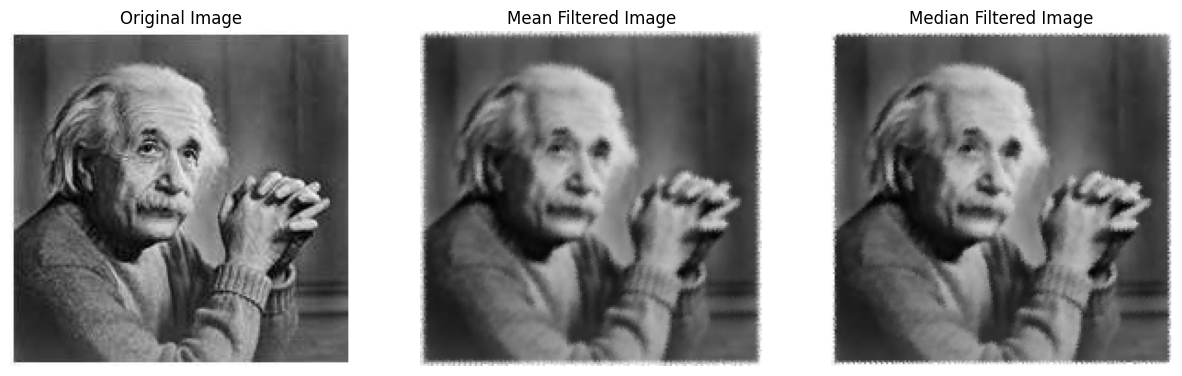

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def build_neighbor_list(triangles, n_vertices):
    """
    Xây dựng danh sách các đỉnh lân cận cho mỗi đỉnh trong mesh.
    
    Parameters:
    - triangles: mảng (n_triangles, 3) chứa chỉ số của 3 đỉnh cho mỗi tam giác
    - n_vertices: số lượng đỉnh trong mesh
    
    Returns:
    - neighbors: danh sách các tập hợp chứa chỉ số các đỉnh lân cận cho mỗi đỉnh
    """
    neighbors = [set() for _ in range(n_vertices)]
    for tri in triangles:
        i, j, k = tri
        neighbors[i].add(j)
        neighbors[i].add(k)
        neighbors[j].add(i)
        neighbors[j].add(k)
        neighbors[k].add(i)
        neighbors[k].add(j)
    return neighbors

def mean_filter(z, neighbors):
    """
    Áp dụng bộ lọc mean lên tọa độ Z của các đỉnh trong mesh.
    Giá trị Z mới của mỗi đỉnh là trung bình của Z của nó và các đỉnh lân cận.
    
    Parameters:
    - z: mảng (n_vertices,) chứa giá trị Z (gray-level) của các đỉnh
    - neighbors: danh sách các đỉnh lân cận cho mỗi đỉnh
    
    Returns:
    - new_z: mảng (n_vertices,) chứa giá trị Z mới sau khi lọc
    """
    new_z = np.zeros_like(z)
    for v in range(len(z)):
        patch_z = [z[v]] + [z[n] for n in neighbors[v]]
        new_z[v] = np.mean(patch_z)
    return new_z

def median_filter(z, neighbors):
    """
    Áp dụng bộ lọc median lên tọa độ Z của các đỉnh trong mesh.
    Giá trị Z mới của mỗi đỉnh là trung vị của Z của nó và các đỉnh lân cận.
    
    Parameters:
    - z: mảng (n_vertices,) chứa giá trị Z (gray-level) của các đỉnh
    - neighbors: danh sách các đỉnh lân cận cho mỗi đỉnh
    
    Returns:
    - new_z: mảng (n_vertices,) chứa giá trị Z mới sau khi lọc
    """
    new_z = np.zeros_like(z)
    for v in range(len(z)):
        patch_z = [z[v]] + [z[n] for n in neighbors[v]]
        new_z[v] = np.median(patch_z)
    return new_z

def reconstruct_image_from_mesh(mesh, z_values, image_shape):
    """
    Tái tạo ảnh từ mesh bằng cách sử dụng giá trị Z đã lọc.
    
    Parameters:
    - mesh: dictionary chứa 'vertices' và 'triangles'
    - z_values: mảng giá trị Z (gray-level) của các đỉnh
    - image_shape: tuple (height, width) của ảnh
    
    Returns:
    - reconstructed_image: mảng numpy đại diện cho ảnh tái tạo
    """
    height, width = image_shape
    reconstructed_image = np.zeros((height, width), dtype=np.float32)
    counts = np.zeros((height, width), dtype=np.float32)

    vertices = mesh['vertices']
    triangles = mesh['triangles']

    for tri in triangles:
        # Lấy tọa độ và giá trị Z của 3 đỉnh của tam giác
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        z0, z1, z2 = z_values[tri[0]], z_values[tri[1]], z_values[tri[2]]

        # Tìm bounding box của tam giác
        x_min = int(max(0, min(v0[0], v1[0], v2[0])))
        x_max = int(min(width - 1, max(v0[0], v1[0], v2[0])))
        y_min = int(max(0, min(v0[1], v1[1], v2[1])))
        y_max = int(min(height - 1, max(v0[1], v1[1], v2[1])))

        # Kiểm tra từng pixel trong bounding box
        for y in range(y_min, y_max + 1):
            for x in range(x_min, x_max + 1):
                # Tọa độ pixel hiện tại
                p = np.array([x, y])

                # Tính tọa độ barycentric để kiểm tra pixel có nằm trong tam giác không
                v0_to_v1 = v1 - v0
                v0_to_v2 = v2 - v0
                v0_to_p = p - v0

                dot00 = np.dot(v0_to_v2, v0_to_v2)
                dot01 = np.dot(v0_to_v2, v0_to_v1)
                dot02 = np.dot(v0_to_v2, v0_to_p)
                dot11 = np.dot(v0_to_v1, v0_to_v1)
                dot12 = np.dot(v0_to_v1, v0_to_p)

                inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
                u = (dot11 * dot02 - dot01 * dot12) * inv_denom
                v = (dot00 * dot12 - dot01 * dot02) * inv_denom

                # Nếu pixel nằm trong tam giác
                if (u >= 0) and (v >= 0) and (u + v <= 1):
                    # Nội suy giá trị Z tại pixel sử dụng tọa độ barycentric
                    w = 1 - u - v
                    z = w * z0 + u * z1 + v * z2
                    reconstructed_image[y, x] += z
                    counts[y, x] += 1

    # Chuẩn hóa ảnh tái tạo (trung bình giá trị tại các pixel có chồng lấn)
    mask = counts > 0
    reconstructed_image[mask] /= counts[mask]
    return reconstructed_image

# Áp dụng bộ lọc lên mesh
if mesh:
    print("Áp dụng bộ lọc lên mesh...")
    neighbors = build_neighbor_list(mesh['triangles'], len(mesh['vertices']))
    z_mean = mean_filter(mesh['z'], neighbors)
    z_median = median_filter(mesh['z'], neighbors)

    # Tái tạo ảnh từ các giá trị Z đã lọc
    image_shape = image_array.shape
    mean_filtered_image = reconstruct_image_from_mesh(mesh, z_mean, image_shape)
    median_filtered_image = reconstruct_image_from_mesh(mesh, z_median, image_shape)

    # Hiển thị ảnh gốc và ảnh đã lọc
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mean_filtered_image, cmap='gray')
    plt.title('Mean Filtered Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(median_filtered_image, cmap='gray')
    plt.title('Median Filtered Image')
    plt.axis('off')

    plt.show()
else:
    print("Không thể áp dụng bộ lọc vì mesh không được tạo.")

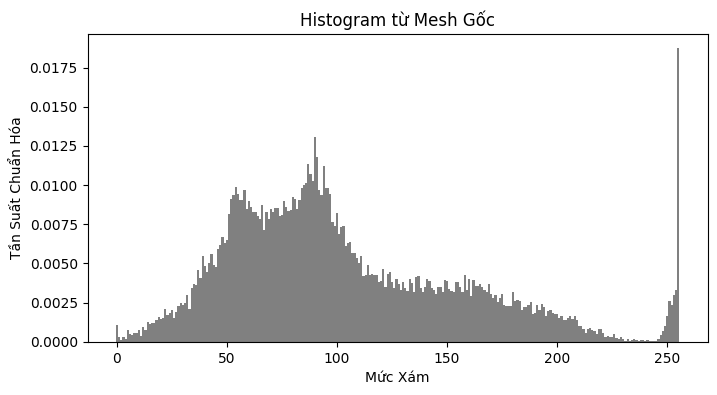

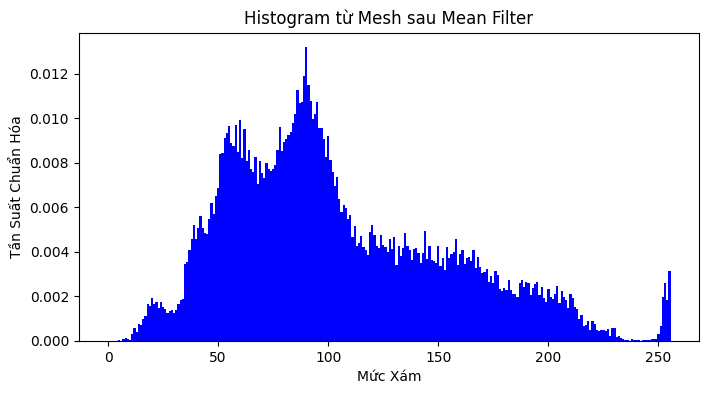

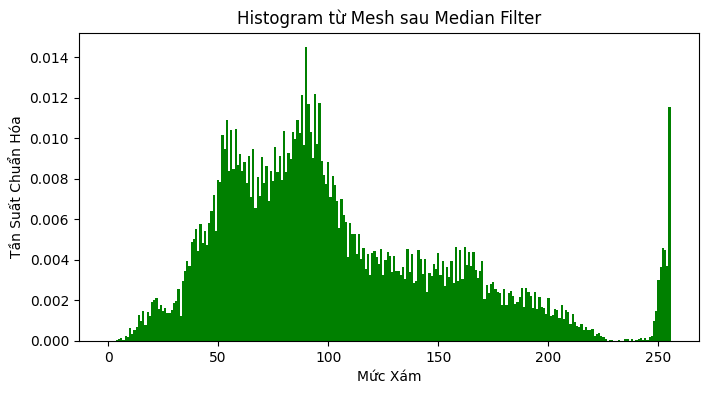

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def generate_histogram_from_mesh(mesh, z_values, image_shape, num_gray_levels=256):
    """
    Sinh histogram từ triangular mesh theo phương pháp trong phần 2.2.
    
    Parameters:
    - mesh: dictionary chứa 'vertices' và 'triangles'
    - z_values: mảng giá trị Z (gray-level) của các đỉnh
    - image_shape: tuple (height, width) của ảnh
    - num_gray_levels: số mức xám (mặc định 256)
    
    Returns:
    - histogram: mảng numpy chứa histogram chuẩn hóa
    """
    height, width = image_shape
    counters = np.zeros(num_gray_levels, dtype=np.float32)
    total_pixels = 0

    vertices = mesh['vertices']
    triangles = mesh['triangles']

    for tri in triangles:
        # Lấy tọa độ và giá trị Z của 3 đỉnh của tam giác
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        z0, z1, z2 = z_values[tri[0]], z_values[tri[1]], z_values[tri[2]]

        # Tìm bounding box của tam giác
        x_min = int(max(0, min(v0[0], v1[0], v2[0])))
        x_max = int(min(width - 1, max(v0[0], v1[0], v2[0])))
        y_min = int(max(0, min(v0[1], v1[1], v2[1])))
        y_max = int(min(height - 1, max(v0[1], v1[1], v2[1])))

        # Duyệt qua các pixel trong bounding box
        for y in range(y_min, y_max + 1):
            for x in range(x_min, x_max + 1):
                p = np.array([x, y])

                # Tính tọa độ barycentric
                v0_to_v1 = v1 - v0
                v0_to_v2 = v2 - v0
                v0_to_p = p - v0

                dot00 = np.dot(v0_to_v2, v0_to_v2)
                dot01 = np.dot(v0_to_v2, v0_to_v1)
                dot02 = np.dot(v0_to_v2, v0_to_p)
                dot11 = np.dot(v0_to_v1, v0_to_v1)
                dot12 = np.dot(v0_to_v1, v0_to_p)

                inv_denom = 1 / (dot00 * dot11 - dot01 * dot01 + 1e-10)  # Tránh chia cho 0
                u = (dot11 * dot02 - dot01 * dot12) * inv_denom
                v = (dot00 * dot12 - dot01 * dot02) * inv_denom
                w = 1 - u - v

                # Kiểm tra nếu pixel nằm trong tam giác
                if w >= 0 and u >= 0 and v >= 0 and w <= 1 and u <= 1 and v <= 1:
                    # Nội suy giá trị Z
                    z = w * z0 + u * z1 + v * z2
                    gray_level = int(round(z))
                    if 0 <= gray_level < num_gray_levels:
                        counters[gray_level] += 1
                        total_pixels += 1

    # Chuẩn hóa histogram
    if total_pixels > 0:
        histogram = counters / total_pixels
    else:
        histogram = counters

    return histogram

# Sinh histogram từ mesh gốc
if 'mesh' in globals() and 'image_array' in globals():
    histogram_original = generate_histogram_from_mesh(mesh, mesh['z'], image_array.shape)

    # Hiển thị histogram của mesh gốc
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(histogram_original)), histogram_original, width=1.0, color='gray')
    plt.title('Histogram từ Mesh Gốc')
    plt.xlabel('Mức Xám')
    plt.ylabel('Tần Suất Chuẩn Hóa')
    plt.show()

    # Sinh histogram từ mesh đã lọc (mean filter)
    if 'z_mean' in globals():
        histogram_mean = generate_histogram_from_mesh(mesh, z_mean, image_array.shape)
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(histogram_mean)), histogram_mean, width=1.0, color='blue')
        plt.title('Histogram từ Mesh sau Mean Filter')
        plt.xlabel('Mức Xám')
        plt.ylabel('Tần Suất Chuẩn Hóa')
        plt.show()

    # Sinh histogram từ mesh đã lọc (median filter)
    if 'z_median' in globals():
        histogram_median = generate_histogram_from_mesh(mesh, z_median, image_array.shape)
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(histogram_median)), histogram_median, width=1.0, color='green')
        plt.title('Histogram từ Mesh sau Median Filter')
        plt.xlabel('Mức Xám')
        plt.ylabel('Tần Suất Chuẩn Hóa')
        plt.show()
else:
    print("Vui lòng chạy Cell 1 và Cell 2 trước để định nghĩa 'mesh', 'image_array', 'z_mean', và 'z_median'.")

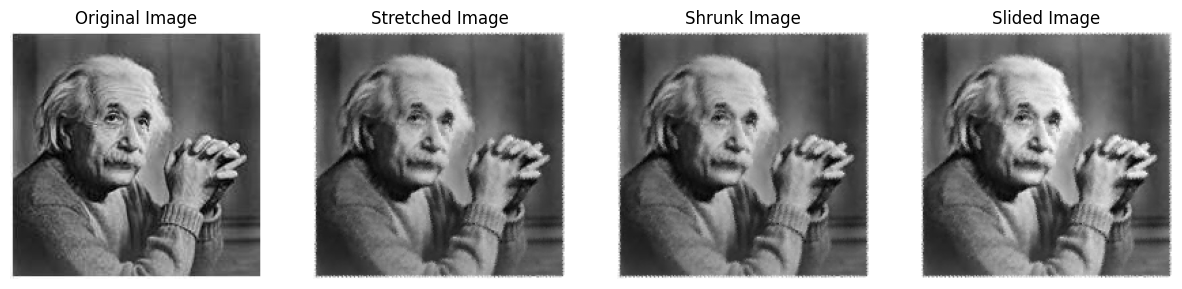

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Định nghĩa các hàm biến đổi histogram
def stretch_histogram(z, min_z, max_z):
    """
    Kéo giãn histogram của z để giá trị nhỏ nhất là min_z và lớn nhất là max_z.
    
    Parameters:
    - z: mảng giá trị Z (gray-level) của các đỉnh
    - min_z: giá trị Z nhỏ nhất mong muốn
    - max_z: giá trị Z lớn nhất mong muốn
    
    Returns:
    - z_stretched: mảng Z sau khi kéo giãn
    """
    z_min, z_max = np.min(z), np.max(z)
    if z_max > z_min:
        z_stretched = min_z + (z - z_min) * (max_z - min_z) / (z_max - z_min)
    else:
        z_stretched = z.copy()
    return np.clip(z_stretched, 0, 255)

def shrink_histogram(z, min_z, max_z):
    """
    Co rút histogram của z vào khoảng [min_z, max_z] bằng cách biến đổi tuyến tính.

    Parameters:
    - z: mảng giá trị Z (gray-level) của các đỉnh
    - min_z: giá trị Z nhỏ nhất sau khi co rút
    - max_z: giá trị Z lớn nhất sau khi co rút

    Returns:
    - z_shrunk: mảng Z sau khi co rút tuyến tính
    """
    z_min, z_max = np.min(z), np.max(z)
    if z_max > z_min:
        z_shrunk = min_z + (z - z_min) * (max_z - min_z) / (z_max - z_min)
    else:
        z_shrunk = z.copy()
    return np.clip(z_shrunk, 0, 255)
def slide_histogram(z, offset):
    """
    Dịch chuyển histogram của z bằng cách cộng thêm offset.
    
    Parameters:
    - z: mảng giá trị Z (gray-level) của các đỉnh
    - offset: giá trị dịch chuyển
    
    Returns:
    - z_slided: mảng Z sau khi dịch chuyển
    """
    z_slided = z + offset
    return np.clip(z_slided, 0, 255)

# Áp dụng các phép biến đổi lên giá trị Z của mesh
if 'mesh' in globals() and 'image_array' in globals():
    # Giá trị ví dụ cho stretching, shrinking, và sliding
    min_z_stretch = 0
    max_z_stretch = 255
    min_z_shrink = 50
    max_z_shrink = 200
    offset_slide = 30

    # Kéo giãn histogram
    z_stretched = stretch_histogram(mesh['z'], min_z_stretch, max_z_stretch)
    stretched_image = reconstruct_image_from_mesh(mesh, z_stretched, image_array.shape)

    # Co rút histogram
    z_shrunk = shrink_histogram(mesh['z'], min_z_shrink, max_z_shrink)
    shrunk_image = reconstruct_image_from_mesh(mesh, z_shrunk, image_array.shape)

    # Dịch chuyển histogram
    z_slided = slide_histogram(mesh['z'], offset_slide)
    slided_image = reconstruct_image_from_mesh(mesh, z_slided, image_array.shape)

    # Hiển thị kết quả
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(stretched_image, cmap='gray')
    plt.title('Stretched Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(shrunk_image, cmap='gray')
    plt.title('Shrunk Image')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(slided_image, cmap='gray')
    plt.title('Slided Image')
    plt.axis('off')

    plt.show()
else:
    print("Vui lòng chạy Cell 1 và Cell 2 trước để định nghĩa 'mesh' và 'image_array'.")